In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import torch
from torch.utils.data import Dataset

np.random.seed(0)  # Seed for reproducibility


# Function to create a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


# Function to apply the bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def generate_signals(fs=21000, T=0.01):
    """
    :param fs: Sampling frequency in Hz
    :param T: Length of signal in seconds
    :return: 
    """
    num_frequencies = np.random.randint(50, 100)  # Randomly choose how many frequencies to combine
    frequencies = np.random.randint(300, 10000, num_frequencies)
    phases = np.random.rand(num_frequencies) * 2 * np.pi
    # print("frequencies", frequencies)
    low_cut = 800.0
    high_cut = 2200.0

    # Time array
    t = np.linspace(0, T, int(T * fs), endpoint=False)

    # Generate a random continuous periodic signal
    signal = sum(np.sin(2 * np.pi * f * t + phase) for f, phase in zip(frequencies, phases))
    signal = signal / np.max(signal)

    # Add random noise to the signal
    noise = np.random.normal(0, 0.1, signal.shape)
    signal += noise
    signal = signal / np.max(signal)

    # Apply bandpass filter
    return t, signal, butter_bandpass_filter(signal, low_cut, high_cut, fs, order=6)


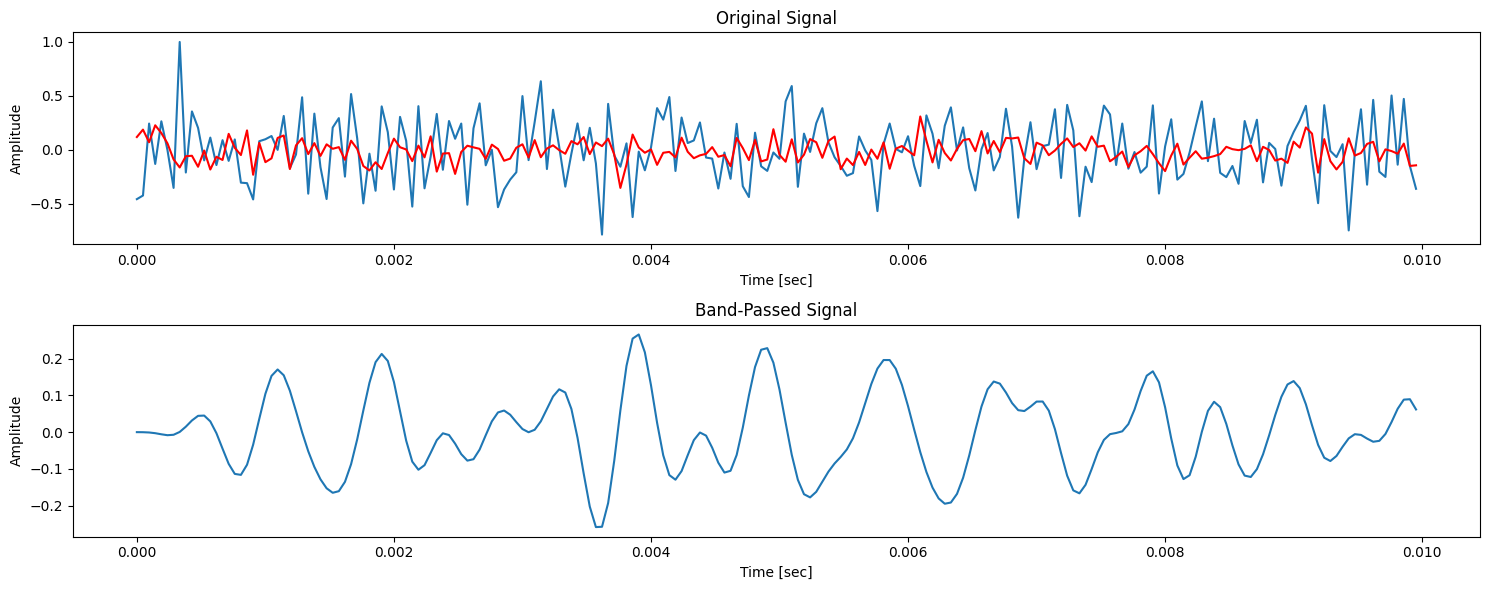

In [19]:
t, signal, filtered_signal = generate_signals()
# Plotting
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title('Original Signal')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(t, filtered_signal)
plt.title('Band-Passed Signal')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [82]:
class SignalDataset(Dataset):
    def __init__(self, size, fs=21000, T=0.01):
        """
        :param size: Number of samples in the dataset
        :param fs: Sampling frequency in Hz
        :param T: Length of each signal in seconds
        """
        self.size = size
        self.fs = fs
        self.T = T

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        _, signal, filtered_signal = generate_signals(self.fs, self.T)
        # Convert to PyTorch tensors
        signal_tensor = torch.tensor(signal, dtype=torch.float32)
        filtered_signal_tensor = torch.tensor(filtered_signal, dtype=torch.float32)
        return torch.unsqueeze(signal_tensor,dim=-1), torch.unsqueeze(filtered_signal_tensor,dim=-1)

In [95]:

class LSTMPredictor(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = torch.nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out)
        return predictions


In [118]:
model = LSTMPredictor()

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataset = SignalDataset(size=600)  # 600 signals
val_dataset = SignalDataset(size=100)  # 100 signals
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
epochs = 50

train_losses = []
val_losses = []
for i in range(epochs):
    epoch_loss = 0
    for seq, labels in dataloader:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        epoch_loss += single_loss
        optimizer.step()
    train_losses.append(epoch_loss)
    # print(f'epoch: {i},  loss: {epoch_loss.item()}')

    if i % 5 == 0:
        model.eval()
        val_loss = 0
        for seq, labels in val_dataloader:
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            val_loss += single_loss
        print(f'VAL: epoch: {i},  val loss: {val_loss.item()}')
        val_losses.append(val_loss)
        model.train()


VAL: epoch: 0,  val loss: 0.35688507556915283
VAL: epoch: 5,  val loss: 0.3326578736305237
VAL: epoch: 10,  val loss: 0.13885647058486938
VAL: epoch: 15,  val loss: 0.02178046479821205
VAL: epoch: 20,  val loss: 0.00444061029702425
VAL: epoch: 25,  val loss: 0.0036513074301183224
VAL: epoch: 30,  val loss: 0.0012869997881352901
VAL: epoch: 35,  val loss: 0.0005859419470652938
VAL: epoch: 40,  val loss: 0.0004440538468770683
VAL: epoch: 45,  val loss: 0.0004239521804265678


In [85]:
# torch.save(model.state_dict(), './checkpoints/100_epochs')

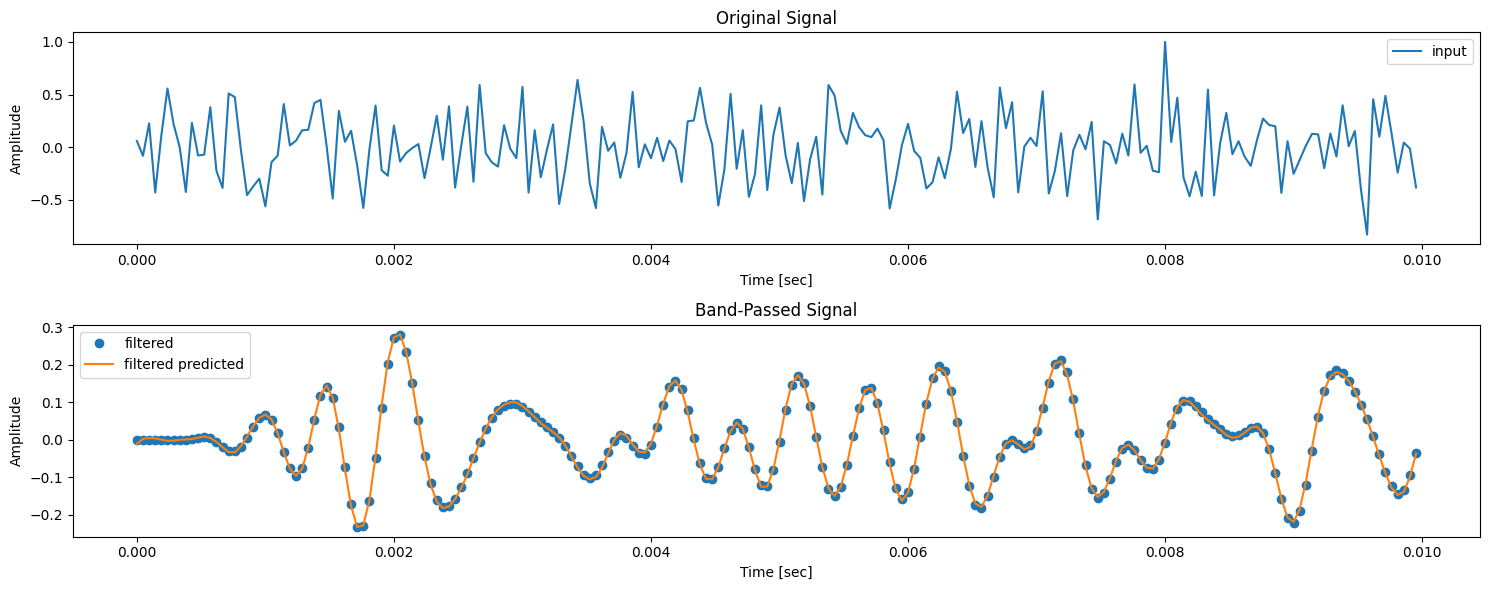

In [119]:
t, signal, filtered_signal = generate_signals()
pred = model(torch.tensor(signal, dtype=torch.float).view(1, len(signal), 1))
predicted_filtered_signal = pred.view(len(signal)).detach()
# Plotting
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='input')
plt.title('Original Signal')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(t, filtered_signal, 'o', label='filtered')
plt.plot(t, predicted_filtered_signal, label='filtered predicted')
plt.legend(loc='best')
plt.title('Band-Passed Signal')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()